In [1]:
import numpy as np
import cv2
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import random

data=[]
for i in range(10):
    img = cv2.imread('dataset/%s.jpg' %i)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    (threshi, final_img) = cv2.threshold(img_gray, 0, 1, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    data.append(np.array(final_img, dtype=np.float32).flatten())



In [2]:
import torch
from torch.autograd import Variable

In [3]:
x_data = Variable(torch.Tensor([data]))
y_data = Variable(torch.Tensor([data]))
 
class Perceptron(torch.nn.Module):
 
    def __init__(self):
        super(Perceptron, self).__init__()
        self.linear = torch.nn.Linear(256, 256)  # One in and one out
        self.sigmoid = torch.nn.Sigmoid()
    def forward(self, x):
        out = self.linear(x)
        out = self.sigmoid(out)
        return out
 
# our model
our_model = Perceptron()
 
criterion = torch.nn.MSELoss(size_average = False)
optimizer = torch.optim.SGD(our_model.parameters(), lr = 0.01)
 
for epoch in range(1000):
 
    # Forward pass: Compute predicted y by passing
    # x to the model
    pred_y = our_model(x_data)
 
    # Compute and print loss
    loss = criterion(pred_y, y_data)
 
    # Zero gradients, perform a backward pass,
    # and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print('epoch {}, loss {}'.format(epoch, loss.item()))
 


C:\Users\risha\AppData\Local\Temp/ipykernel_69804/611574549.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ..\torch\csrc\utils\tensor_new.cpp:201.)
  x_data = Variable(torch.Tensor([data]))
C:\Users\risha\anaconda3\envs\pytorch_1.7\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


epoch 0, loss 668.02294921875
epoch 1, loss 159.56796264648438
epoch 2, loss 149.4871063232422
epoch 3, loss 146.2294158935547
epoch 4, loss 143.32969665527344
epoch 5, loss 141.53871154785156
epoch 6, loss 136.50245666503906
epoch 7, loss 136.35684204101562
epoch 8, loss 132.9449920654297
epoch 9, loss 132.36920166015625
epoch 10, loss 126.25883483886719
epoch 11, loss 126.8389892578125
epoch 12, loss 121.65155029296875
epoch 13, loss 122.70723724365234
epoch 14, loss 116.07463836669922
epoch 15, loss 115.67552185058594
epoch 16, loss 111.70692443847656
epoch 17, loss 111.75728607177734
epoch 18, loss 107.98528289794922
epoch 19, loss 108.51930236816406
epoch 20, loss 102.62737274169922
epoch 21, loss 101.73676300048828
epoch 22, loss 97.6654052734375
epoch 23, loss 98.38528442382812
epoch 24, loss 92.16310119628906
epoch 25, loss 90.81266021728516
epoch 26, loss 87.2525405883789
epoch 27, loss 87.1283187866211
epoch 28, loss 81.06021118164062
epoch 29, loss 80.07545471191406
epoch 30

epoch 279, loss 4.459738731384277
epoch 280, loss 4.4416117668151855
epoch 281, loss 4.423625946044922
epoch 282, loss 4.405777931213379
epoch 283, loss 4.388067245483398
epoch 284, loss 4.370492458343506
epoch 285, loss 4.353050708770752
epoch 286, loss 4.33574104309082
epoch 287, loss 4.318563938140869
epoch 288, loss 4.301515579223633
epoch 289, loss 4.284595489501953
epoch 290, loss 4.267801284790039
epoch 291, loss 4.251133918762207
epoch 292, loss 4.234588623046875
epoch 293, loss 4.218166828155518
epoch 294, loss 4.201866626739502
epoch 295, loss 4.185686111450195
epoch 296, loss 4.169624328613281
epoch 297, loss 4.153679847717285
epoch 298, loss 4.137851238250732
epoch 299, loss 4.122138500213623
epoch 300, loss 4.10653829574585
epoch 301, loss 4.091052055358887
epoch 302, loss 4.075675964355469
epoch 303, loss 4.0604095458984375
epoch 304, loss 4.045253276824951
epoch 305, loss 4.030204772949219
epoch 306, loss 4.015262603759766
epoch 307, loss 4.000426292419434
epoch 308, los

epoch 616, loss 1.8349940776824951
epoch 617, loss 1.8317128419876099
epoch 618, loss 1.8284430503845215
epoch 619, loss 1.8251850605010986
epoch 620, loss 1.8219377994537354
epoch 621, loss 1.8187018632888794
epoch 622, loss 1.8154771327972412
epoch 623, loss 1.8122634887695312
epoch 624, loss 1.8090605735778809
epoch 625, loss 1.805869460105896
epoch 626, loss 1.8026885986328125
epoch 627, loss 1.7995184659957886
epoch 628, loss 1.7963595390319824
epoch 629, loss 1.7932111024856567
epoch 630, loss 1.7900736331939697
epoch 631, loss 1.7869465351104736
epoch 632, loss 1.7838302850723267
epoch 633, loss 1.7807246446609497
epoch 634, loss 1.7776291370391846
epoch 635, loss 1.7745444774627686
epoch 636, loss 1.7714699506759644
epoch 637, loss 1.7684059143066406
epoch 638, loss 1.765352487564087
epoch 639, loss 1.7623088359832764
epoch 640, loss 1.759275197982788
epoch 641, loss 1.7562520503997803
epoch 642, loss 1.753238558769226
epoch 643, loss 1.750235676765442
epoch 644, loss 1.7472424

epoch 924, loss 1.177316427230835
epoch 925, loss 1.175934076309204
epoch 926, loss 1.1745550632476807
epoch 927, loss 1.1731793880462646
epoch 928, loss 1.1718065738677979
epoch 929, loss 1.1704370975494385
epoch 930, loss 1.1690703630447388
epoch 931, loss 1.1677069664001465
epoch 932, loss 1.1663470268249512
epoch 933, loss 1.164989709854126
epoch 934, loss 1.1636357307434082
epoch 935, loss 1.1622848510742188
epoch 936, loss 1.160936713218689
epoch 937, loss 1.1595919132232666
epoch 938, loss 1.158250093460083
epoch 939, loss 1.1569112539291382
epoch 940, loss 1.1555755138397217
epoch 941, loss 1.1542428731918335
epoch 942, loss 1.1529130935668945
epoch 943, loss 1.1515862941741943
epoch 944, loss 1.1502625942230225
epoch 945, loss 1.1489416360855103
epoch 946, loss 1.147623896598816
epoch 947, loss 1.1463088989257812
epoch 948, loss 1.1449968814849854
epoch 949, loss 1.1436880826950073
epoch 950, loss 1.1423817873001099
epoch 951, loss 1.1410785913467407
epoch 952, loss 1.13977837

In [4]:
p = our_model(Variable(torch.Tensor([data[9]]))).cpu().detach().numpy()
p = p.reshape(16, 16)
p[p <= 0.5] = 0
p[p > 0.5] = 1
p

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 0., 0., 1., 1., 0., 0., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 0., 0., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 0., 0., 1., 1., 0., 0., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1.,

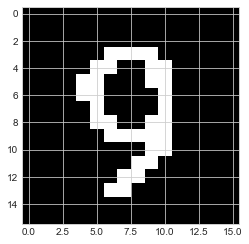

In [5]:
import matplotlib.pyplot as plt
plt.imshow(p)

In [6]:
def generate_rescaled_inputs(data):
    input_data = []
    
    for i in range(10):
        data_sample = Variable(torch.Tensor([data[i]])).numpy()
        data_sample = data_sample.reshape(16, 16)
        input_data.append(data_sample)
        
    return input_data

In [7]:
def generate_predictions(data):
    predicted_output = []
    
    for i in range(10):
        p = our_model(Variable(torch.Tensor([data[i]]))).cpu().detach().numpy()
        p = p.reshape(16, 16)
        p[p <= 0.5] = 0
        p[p > 0.5] = 1
        predicted_output.append(p)
    
    return predicted_output

In [8]:
def calculate_total_black_pixels(array):
    count = 0
    for a in array:
            count+= np.count_nonzero(a==0)
    return count

In [9]:
def calculate_total_white_pixels(array):
    count = 0
    for a in array:
            count+= np.count_nonzero(a==1)
    return count

In [10]:
def calculate_matching_black_pixels(data1, data2):
    match_ctr = 0
    for i, sample in enumerate(data2):
        for j,d in enumerate(sample):
            if d == 0:
                if data1[i][j] == 0:
                    match_ctr +=1
    return match_ctr

In [11]:
def calculate_mismatching_black_pixels(data1, data2):
    mismatch_ctr = 0
    for i, sample in enumerate(data2):
        for j,d in enumerate(sample):
            if d == 0:
                if not data1[i][j] == 0:
                    mismatch_ctr +=1
    return mismatch_ctr

In [12]:
def compute_error_metrics(input_data, predicted_output):
    f_h = []
    f_fa = []
    
    for ix, data in enumerate(input_data):
        total_black_pixels = calculate_total_black_pixels(input_data[ix])
        total_hits = calculate_matching_black_pixels(input_data[ix], predicted_output[ix])
        fh_ratio = float(total_hits/total_black_pixels)
        print("Fraction of hits is {}".format(fh_ratio))
        f_h.append(fh_ratio)
    
    for ix, data in enumerate(input_data):
        total_white_pixels = calculate_total_white_pixels(input_data[ix])
        total_fa = calculate_mismatching_black_pixels(input_data[ix], predicted_output[ix])
        ffa_ratio = float(total_fa/total_white_pixels)
        print("Fraction of false alarms is {}".format(ffa_ratio))
        f_fa.append(ffa_ratio)
    return f_h, f_fa
    

In [13]:
input_data = generate_rescaled_inputs(data)
predicted_output = generate_predictions(data)

In [14]:
fh, ffa = compute_error_metrics(input_data, predicted_output)

Fraction of hits is 1.0
Fraction of hits is 1.0
Fraction of hits is 1.0
Fraction of hits is 1.0
Fraction of hits is 1.0
Fraction of hits is 1.0
Fraction of hits is 1.0
Fraction of hits is 1.0
Fraction of hits is 1.0
Fraction of hits is 1.0
Fraction of false alarms is 0.0
Fraction of false alarms is 0.0
Fraction of false alarms is 0.0
Fraction of false alarms is 0.0
Fraction of false alarms is 0.0
Fraction of false alarms is 0.0
Fraction of false alarms is 0.0
Fraction of false alarms is 0.0
Fraction of false alarms is 0.0
Fraction of false alarms is 0.0


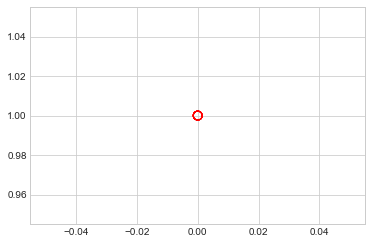

In [15]:
plt.scatter(ffa, fh, s=80, facecolors='none', edgecolors='r')
plt.show()

In [16]:
def gaussy(X_noisy_temp,std_dev):   
    random.seed(15)
    mean=0.0
    random_index=random.sample(range(256), 25)
    gauss=np.random.normal(mean,std_dev,25)
    for j in range(10):
        for i in range(25):
            noisy_index=random_index[i]
            X_noisy_temp[j][noisy_index]=X_noisy_temp[j][noisy_index]+gauss[i]

    for j in range(10):
        for i in range(256):
            X_noisy_temp[j][i] = (X_noisy_temp[j][i] - np.amin(X_noisy_temp[j]))/(np.amax(X_noisy_temp[j]) - np.amin(X_noisy_temp[j]))
     
    return X_noisy_temp

In [17]:
X_noisy1 = np.copy(data)

In [18]:
fh_1, ffa_1 = compute_error_metrics(input_data, generate_predictions(gaussy(X_noisy1,0.001)))
fh_2, ffa_2 = compute_error_metrics(input_data, generate_predictions(gaussy(X_noisy1,0.002)))
fh_3, ffa_3 = compute_error_metrics(input_data, generate_predictions(gaussy(X_noisy1,0.003)))
fh_4, ffa_4 = compute_error_metrics(input_data, generate_predictions(gaussy(X_noisy1,0.005)))
fh_5, ffa_5 = compute_error_metrics(input_data, generate_predictions(gaussy(X_noisy1,0.01)))
fh_6, ffa_6 = compute_error_metrics(input_data, generate_predictions(gaussy(X_noisy1,0.02)))
fh_7, ffa_7 = compute_error_metrics(input_data, generate_predictions(gaussy(X_noisy1,0.03)))
fh_8, ffa_8 = compute_error_metrics(input_data, generate_predictions(gaussy(X_noisy1,0.05)))
fh_9, ffa_9 = or_metrics(input_data, generate_predictions(gaussy(X_noisy1,0.1)))